Notes: 
- Ranking the probability of patient's fall (e.g. high risk, etc.) might be enough instead of assigning individual patient's fall/non-fall value.
- Missing nursing data is not MCAR -> dummy variables for unknown values might be a good predictors

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#%pip install autoviz
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# Patient Fall Risk Assessment Project

## Section 1: Initial Exploration (EDA)

In this section, we:
- Provide a summary of the dataset
- Identify and handle outliers
- Assess missing data and determine strategies for imputation or removal
- Partition the data into training and testing sets


### 1. Data Overview

The dataset (`kip_sdm_syn.csv`) contains patient information split into two parts:
- **Medical Data:** Age, gender, diagnosis, procedure. This data is available for every patient.
- **Nursing Data:** Fall risk assessment and various risk factors, recorded only for patients at increased risk or exceeding a certain age threshold.

We begin by loading the dataset and examining its structure.

In [2]:
# Load the dataset
path = "../data/kip_sdm_syn.csv"
df = pd.read_csv(path)

# Display the first few rows to understand the structure
print("Data Shape:", df.shape)
df.head()

print("Column Names:", df.columns.tolist())


Data Shape: (40000, 45)
Column Names: ['fallen', 'id', 'age', 'procedure', 'diagnosis', 'c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-jones', 'bed_mobility-skin_condition', 'transfer-impairment', 'transfer', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-how_many_last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-jones', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition

In [3]:
###############################################################################
# 2. IDENTIFY THE TARGET AND DROP 'id'
###############################################################################
# 'fallen' is the target: "Ist der Patient gestürzt?" (logical => True/False).
# 'id' is just an identifier, so typically we don't use it for modeling.

if "id" in df.columns:
    # Keep 'id' in the dataframe for reference if needed, but do not model with it
    # pass
	df.drop(columns=["id"], inplace=True)

if "fallen" not in df.columns:
    raise ValueError("Target column 'fallen' not found in dataset. Please verify.")

In [4]:
###############################################################################
# 3. DOMAIN-SPECIFIC NOTES AND ACTIONS FOR EACH COLUMN
###############################################################################
# From the provided explanations, we have the following categories:
#   - Columns with 0 missing values (fully recorded).
#   - Logical columns with high missingness => means "not assessed" or "unknown".
#   - Jones score columns (character) that might hold numeric or ordinal values.
#   - 'decubitus-risk' and 'fall-risk' (character) with values {0, +, ++} => ordinal.
#   - 'c_zriserh1' is undocumented => decide whether to keep or drop.

# 3.1 Decide how to handle c_zriserh1 (logical, 0 missing, not documented).
#     If truly no documentation, consider dropping it. Otherwise, keep for potential
#     exploratory analysis. Here, we'll drop it for clarity.
if "c_zriserh1" in df.columns:
    df.drop(columns=["c_zriserh1"], inplace=True)


# 3.2 Convert 'decubitus-risk' and 'fall-risk' from {0, +, ++} to ordinal numeric
#     For example: 0 -> 0, + -> 1, ++ -> 2. If these are truly ordinal risk levels,
#     it helps to store them numerically.
risk_mapping = {"0": 0, "+": 1, "++": 2}

if "decubitus-risk" in df.columns:
    df["decubitus-risk"] = df["decubitus-risk"].map(risk_mapping).astype("Int64")

if "fall-risk" in df.columns:
    df["fall-risk"] = df["fall-risk"].map(risk_mapping).astype("Int64")


# 3.3 Convert 'sex' if it’s M/F (or other categories). If it’s just "M"/"W", you can
#     keep it as is or do a binary encoding. For demonstration, let's do a simple map:
sex_map = {"male": 0, "female": 1}
if "sex" in df.columns:
    df["sex"] = df["sex"].map(sex_map).astype("Int64")  # -1 for unknown
    # df["sex"] = df["sex"].map(sex_map).fillna(-1).astype("Int64")  # -1 for unknown

# 3.4 Check if "bed_mobility-jones", "walk-jones", and "transfer" hold numeric
#     or textual codes. They are described as "Jones score" but stored as character.
#     If they are numeric or ordinal, convert them. Otherwise, keep them as categories.
jones_cols = ["bed_mobility-jones", "walk-jones", "transfer"]
for col in jones_cols:
    if col in df.columns:
        # Attempt numeric conversion
        try:
            df[col] = pd.to_numeric(df[col])
            print(f"Converted {col} to numeric.")
        except ValueError:
            # If it fails, treat as categorical
            print(f"{col} remains categorical (couldn't convert to numeric).")

bed_mobility-jones remains categorical (couldn't convert to numeric).
walk-jones remains categorical (couldn't convert to numeric).
transfer remains categorical (couldn't convert to numeric).


In [5]:
bool_vars = [
    "decubitus-admission",
    "decubitus-at_the_moment",
    "bed_mobility-impairment",
    "bed_mobility-skin_condition",
    "transfer-impairment",
    "medical_items",
    "medical_items-skin_condition_at_item_application",
    "fall-last_12_month",
    "fall-while_stay",
    "fall-while_transfer",
    "walk-impairment",
    "excretions-impairment",
    "cognition-impairment",
    "psychotropic_or_sedatives_drugs",
    "diseases",
]

df[bool_vars] = df[bool_vars].astype("boolean")

# Check if any of the boolean variables contain NA values
bool_vars_na = df[bool_vars].isna().any()
print("Boolean variables containing NA values:")
print(bool_vars_na[bool_vars_na])

Boolean variables containing NA values:
decubitus-admission                                 True
decubitus-at_the_moment                             True
bed_mobility-impairment                             True
bed_mobility-skin_condition                         True
transfer-impairment                                 True
medical_items                                       True
medical_items-skin_condition_at_item_application    True
fall-last_12_month                                  True
fall-while_stay                                     True
fall-while_transfer                                 True
walk-impairment                                     True
excretions-impairment                               True
cognition-impairment                                True
psychotropic_or_sedatives_drugs                     True
diseases                                            True
dtype: bool


In [6]:
###############################################################################
# 2. Overview
###############################################################################

# Print the number of rows and columns
print("Number of rows and columns:", df.shape)  # shape returns (rows, columns)

# List all variable names and their data types
print("\nVariable names and their data types:")
print(df.dtypes)  # Displays column names with their data types

# Classify each variable as categorical or numerical
categorical_vars =  ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
numerical_vars =  ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']


print("\nCategorical variables:", categorical_vars)
print("Numerical variables:", numerical_vars)
print("Binary/Boolean variables:, ", bool_vars)

Number of rows and columns: (40000, 43)

Variable names and their data types:
fallen                                                 bool
age                                                   int64
procedure                                            object
diagnosis                                            object
decubitus-admission                                 boolean
decubitus-at_the_moment                             boolean
bed_mobility-impairment                             boolean
bed_mobility-jones                                   object
bed_mobility-skin_condition                         boolean
transfer-impairment                                 boolean
transfer                                             object
medical_items                                       boolean
medical_items-arm_or_leg_splint                        bool
medical_items-A_V_system                               bool
medical_items-plaster_or_neck_brace                    bool
medical_items-compress

In [7]:
print("Column Names:", df.columns.tolist())

Column Names: ['fallen', 'age', 'procedure', 'diagnosis', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-jones', 'bed_mobility-skin_condition', 'transfer-impairment', 'transfer', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-how_many_last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-jones', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropic_or_sedatives_drugs


Key statistics for numerical variables:
                             count      mean      std      min   25%   50%   \
age                          40000.0     57.66  19.124127  19.0  39.0  59.0   
fall-how_many_last_12_month   1400.0  1.754659    1.54334   1.0   1.0   1.0   
decubitus-risk               11489.0  0.297067   0.561279   0.0   0.0   0.0   
fall-risk                    12328.0  0.330873   0.503365   0.0   0.0   0.0   

                             75%   max    median  
age                          74.0  104.0   59.0   
fall-how_many_last_12_month   1.0    5.0    1.0   
decubitus-risk                0.0    2.0    0.0   
fall-risk                     1.0    2.0    0.0   

Generating histograms...


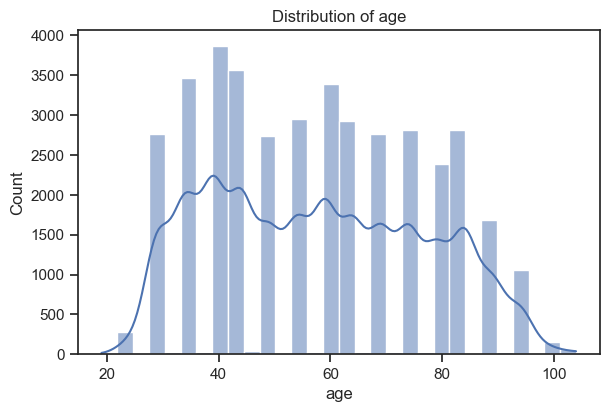

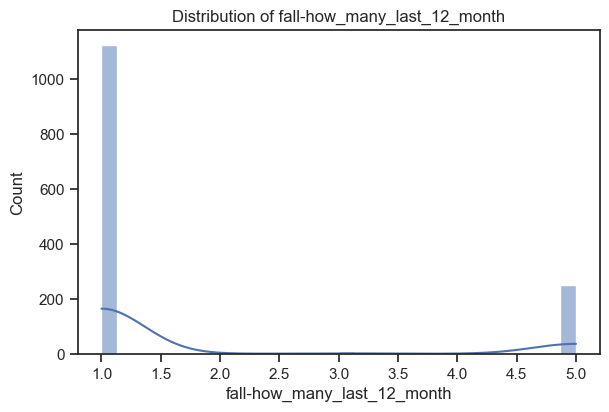

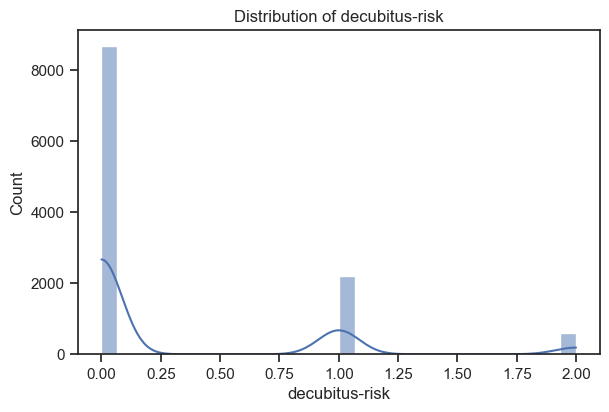

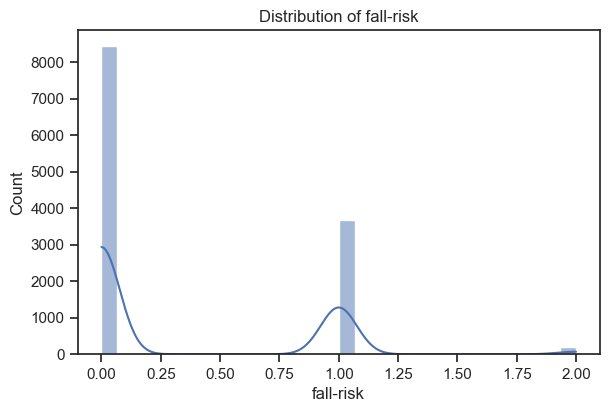

In [8]:
# Compute key statistics for numerical variables
print("\nKey statistics for numerical variables:")
stats = df[numerical_vars].describe().T  # Transpose to make it more readable
stats["median"] = df[numerical_vars].median()  # Add median column
print(stats)  # Print statistics including mean, median, min, max, std deviation

# Create histograms for each numerical variable using Seaborn
print("\nGenerating histograms...")
for col in numerical_vars:
	plt.figure(figsize=(6, 4))  # Set individual plot size
	sns.histplot(df[col], kde=True, bins=30)  # Histogram with KDE overlay
	plt.title(f"Distribution of {col}")  # Set title
	plt.xlabel(col)  # Label x-axis
	plt.ylabel("Count")  # Label y-axis
	plt.show()  # Show the plot

In [9]:
def drop_uninformative_columns(df, missing_threshold=0.8, verbose=True):
    """
    Drops columns with zero (or near-zero) variance and columns with high missingness.

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - missing_threshold (float): Threshold for missing values (e.g. 0.8 = 80%)
    - verbose (bool): If True, prints out dropped columns

    Returns:
    - pd.DataFrame: Cleaned DataFrame
    - list: Dropped columns
    """

    # Step 1: Identify zero-variance columns (NA not included)
    zero_var_cols = []
    for col in df.columns:
        # Count unique values
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 1:
            # This column has zero variance
            zero_var_cols.append(col)

    if verbose:
        print("Zero or near-zero variance columns identified:", zero_var_cols)

    # For columns that AutoViz specifically flagged as zero-variance or low information,
    # you can add them manually to the drop list if you trust that analysis:
    auto_flagged_zero_var = [
        # Example columns from your AutoViz report:
        "medical_items-A_V_system",
        "bed_mobility-jones",              # 93.98% missing, flagged as zero-var
        "bed_mobility-skin_condition",     # 96.11% missing
        "transfer",                        # 92.48% missing
        "medical_items-skin_condition_at_item_application",
        #"fall-how_many_last_12_month",
        "fall-while_stay",
        # etc. (Add any others explicitly flagged as zero variance or "drop before modeling")
    ]

    # Combine both programmatic detection and manually flagged columns
    cols_to_drop_zv = list(set(zero_var_cols + auto_flagged_zero_var))

    if verbose:
        print("Dropping zero-variance columns:", cols_to_drop_zv)

    # Drop zero-variance columns
    df.drop(columns=[col for col in cols_to_drop_zv if col in df.columns],
            inplace=True, errors='ignore')

    # Step 2: Drop high-missingness columns
    missing_rates = df.isnull().mean()
    high_missing_cols = missing_rates[missing_rates > missing_threshold].index.tolist()

    # Combine all columns to drop
    cols_to_drop = list(set(cols_to_drop_zv + high_missing_cols))

    # Drop them
    df_cleaned = df.drop(columns=cols_to_drop, errors='ignore')

    if verbose:
        print(f"Dropped {len(cols_to_drop_zv)} zero-variance columns:")
        print(cols_to_drop_zv)
        print(f"\nDropped {len(high_missing_cols)} high-missingness columns (>{missing_threshold*100}% missing):")
        print(high_missing_cols)
        print(f"\nTotal columns dropped: {len(cols_to_drop)}")

    return df_cleaned, cols_to_drop


# Apply the function to clean the DataFrame
df_cleaned, dropped_columns = drop_uninformative_columns(df, missing_threshold=0.85)

# Print the remaining columns
print("Columns in df_cleaned:", df_cleaned.columns.tolist())
print(f"Number of columns: {len(df_cleaned.columns)}")

Zero or near-zero variance columns identified: ['decubitus-admission', 'medical_items-A_V_system']
Dropping zero-variance columns: ['fall-while_stay', 'decubitus-admission', 'transfer', 'bed_mobility-skin_condition', 'bed_mobility-jones', 'medical_items-skin_condition_at_item_application', 'medical_items-A_V_system']
Dropped 7 zero-variance columns:
['fall-while_stay', 'decubitus-admission', 'transfer', 'bed_mobility-skin_condition', 'bed_mobility-jones', 'medical_items-skin_condition_at_item_application', 'medical_items-A_V_system']

Dropped 2 high-missingness columns (>85.0% missing):
['fall-how_many_last_12_month', 'walk-jones']

Total columns dropped: 9
Columns in df_cleaned: ['fallen', 'age', 'procedure', 'diagnosis', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses',

<Axes: >

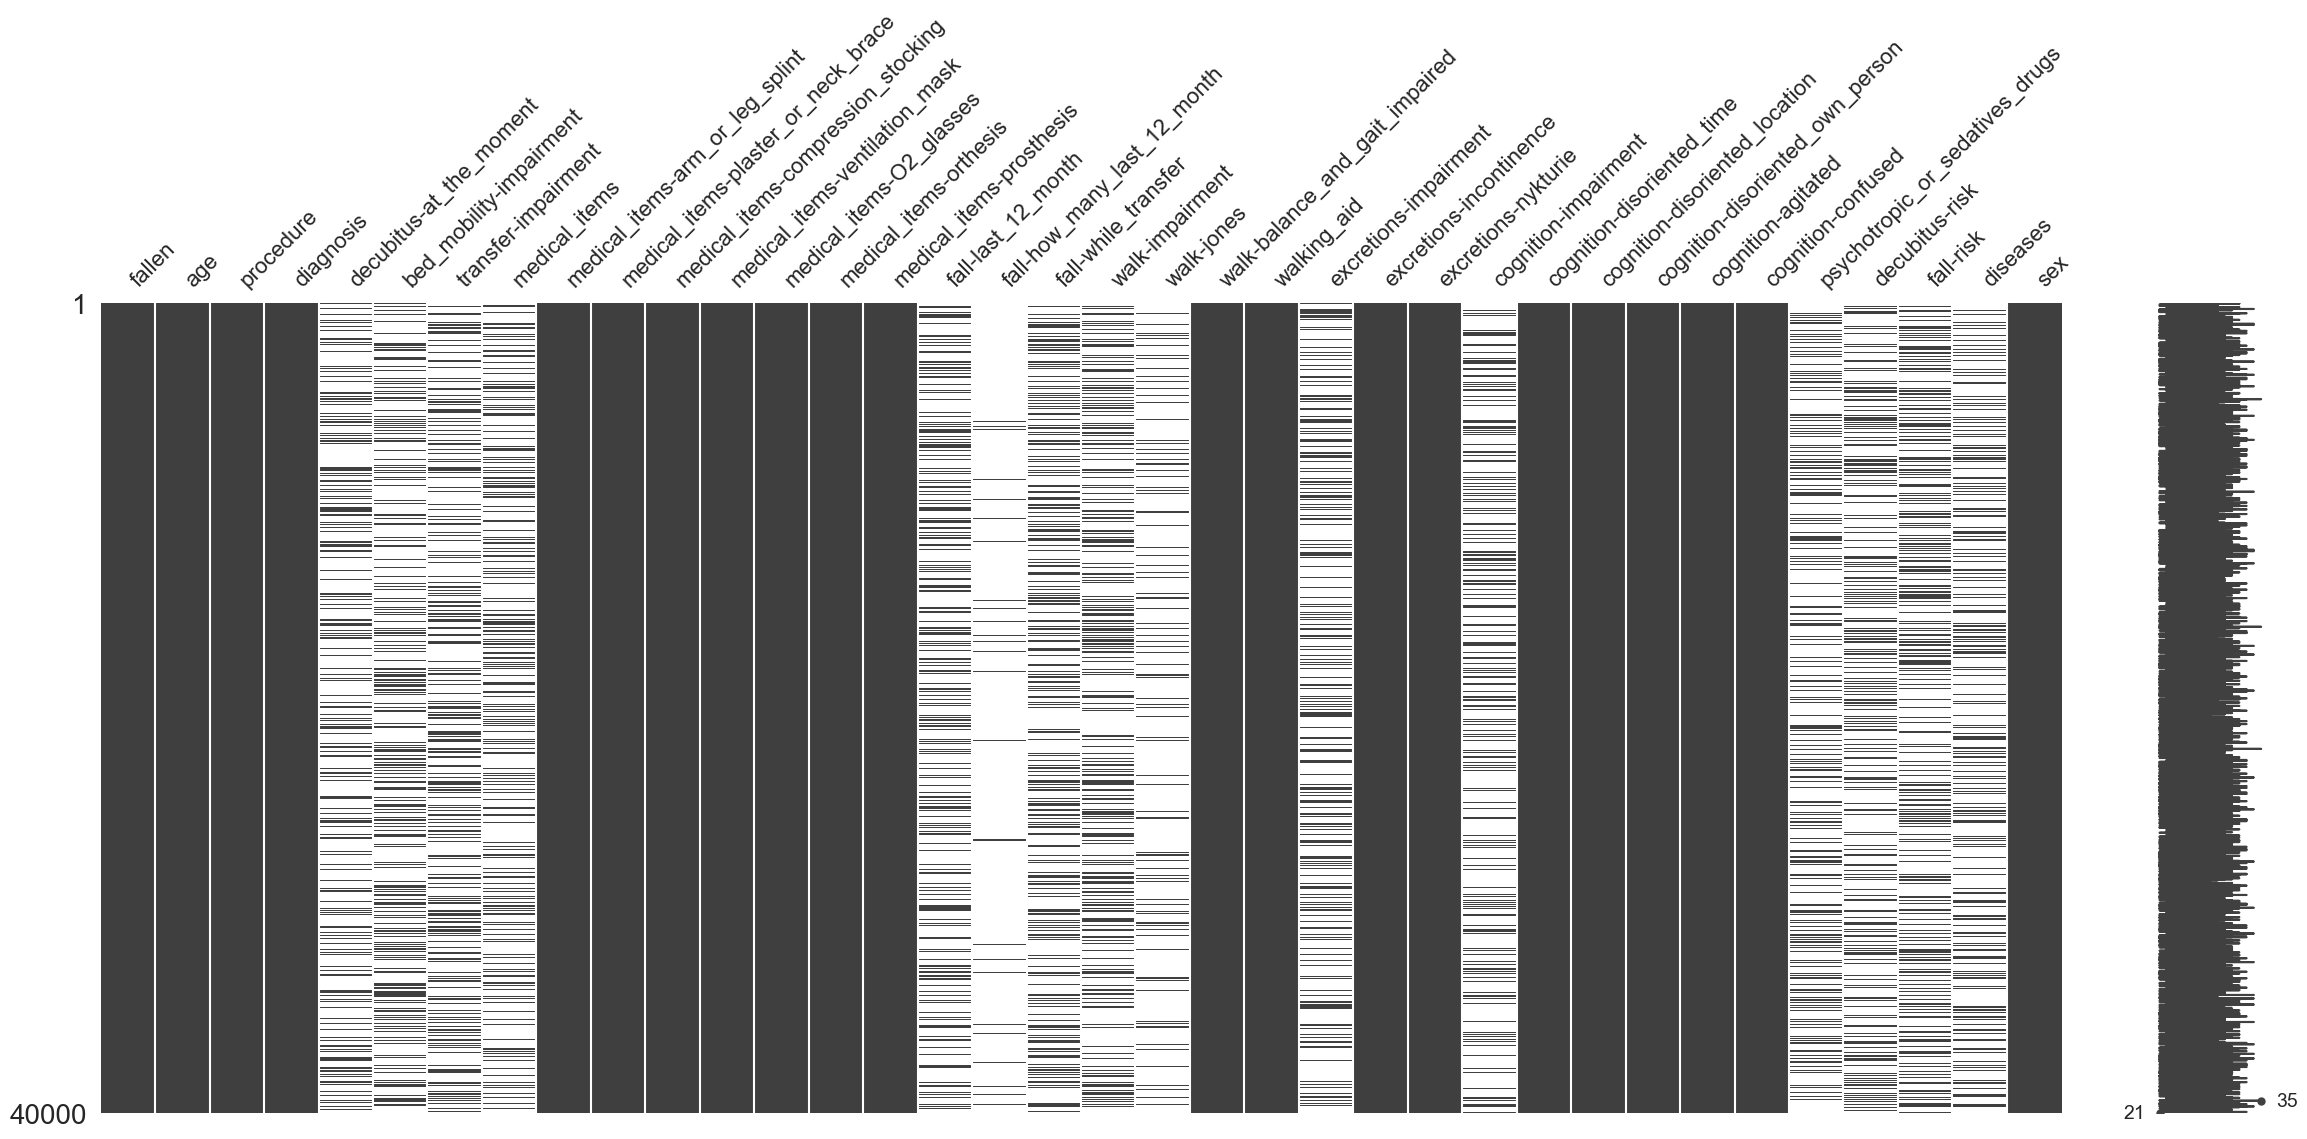

In [10]:
import missingno as msno
msno.matrix(df)

### 2. Outlier Detection and Handling

Outliers can skew the analysis, especially in medical data. Our approach to handle outliers includes:
- **Visualization:** Using boxplots and histograms to visually inspect the distribution of numeric variables.
- **Statistical Methods:** Using the Interquartile Range (IQR) to flag outliers. Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR will be flagged as potential outliers.
- **Handling Strategy:** Depending on the variable and the context, we may:
  - Cap the outliers at the boundary values
  - Remove the data points if they are likely errors
  - Use transformation methods (e.g., log transformation) if the distribution is highly skewed

The code below demonstrates the IQR-based detection for a sample numeric column (e.g., `age`). You should replicate or extend this approach for other numeric variables.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_outliers(df, column):
    """
    Creates a boxplot and histogram for a numeric column.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(y=df[column], ax=axes[0])
    axes[0].set_title(f'Boxplot of {column}')

    sns.histplot(df[column], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {column}')

    plt.tight_layout()
    plt.show()


In [12]:
def detect_outliers_iqr(series):
    """
    Returns lower and upper bounds, and a mask for outliers in the Series.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (series < lower_bound) | (series > upper_bound)

    return lower_bound, upper_bound, outlier_mask


##### Outlier Handling: What’s the Difference?
Capping (Winsorization)	
- Replaces extreme outliers with a threshold (e.g. Q1 - 1.5IQR or Q3 + 1.5IQR)	
- Preserves all rows, reduces impact of outliers	
- Still keeps modified outlier values in dataset	
- When data is mostly valid but has extreme values

Removing
- Deletes rows that contain outlier values	
- Removes truly erroneous data	
- Loses information, can reduce sample size	
- When outliers are likely due to data entry error

Transforming	
- Applies a function (e.g., log, sqrt) to reduce skewness	
- Keeps all data, handles skew	
- Can complicate interpretability	
- When distribution is heavily skewed (e.g. income, lab results)

In [13]:
def handle_outliers(df, column, method="cap"):
    """
    Detects and handles outliers in a column using IQR.

    Parameters:
    - df: DataFrame
    - column: str, column to process
    - method: str, one of ["cap", "remove", "log"]

    Returns:
    - Modified DataFrame
    """
    lower, upper, mask = detect_outliers_iqr(df[column])
    if method == "cap":
        df[column] = df[column].clip(lower, upper)
    elif method == "remove":
        df = df[~mask]
    elif method == "log":
        df[column] = df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
    else:
        raise ValueError("Method must be one of ['cap', 'remove', 'log']")

    print(f"{mask.sum()} outliers handled in '{column}' using '{method}' method.")
    return df


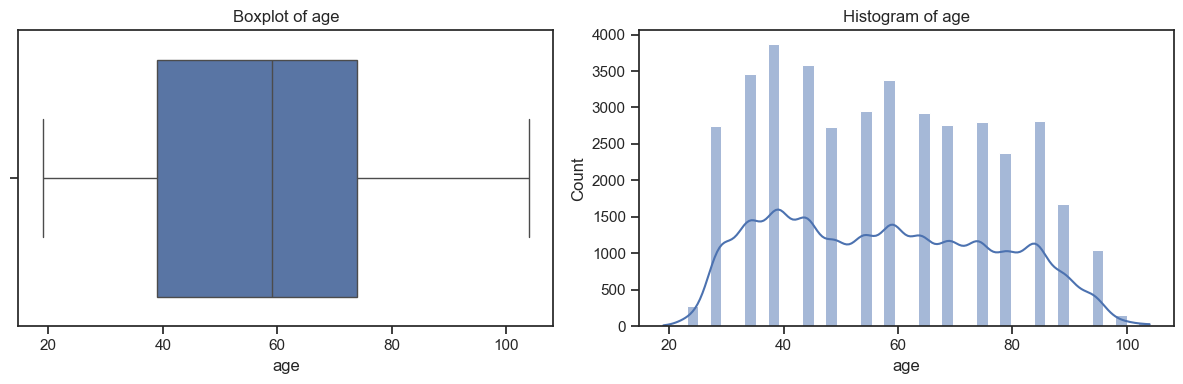

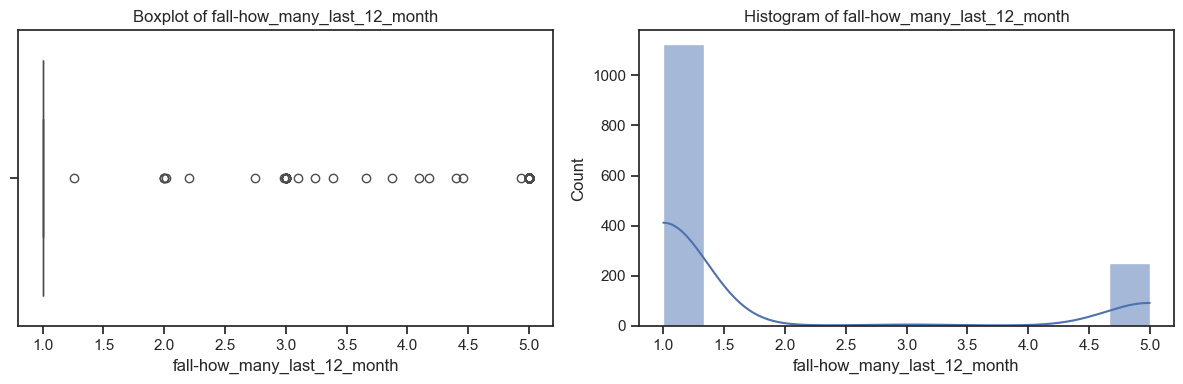

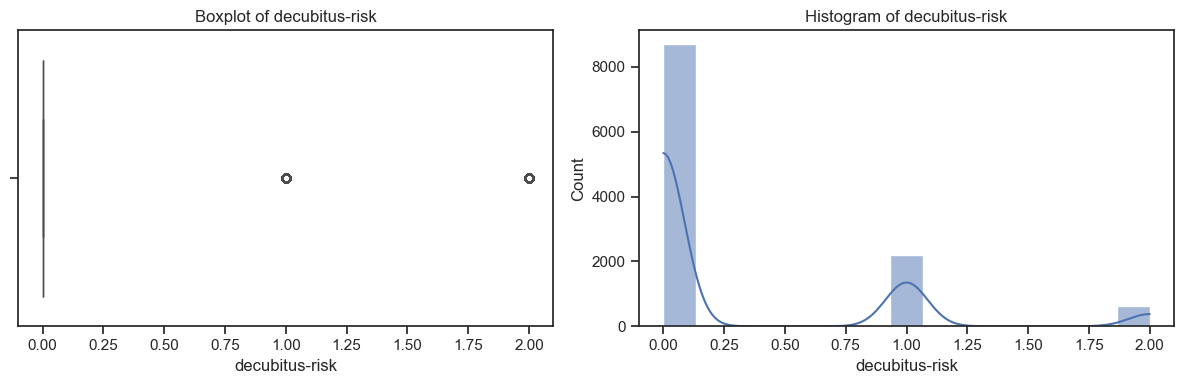

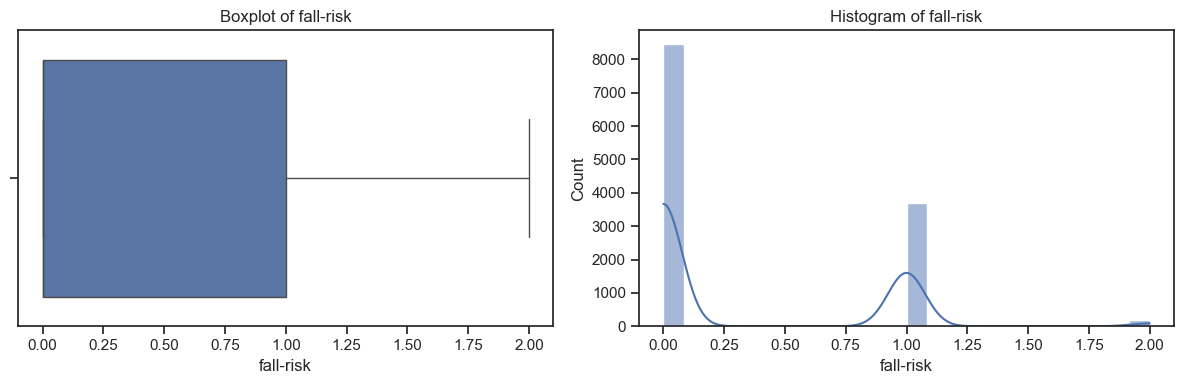

In [14]:
for col in numerical_vars:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col}")

    plt.tight_layout()
    plt.show()

In [15]:
print("Numerical variables:", numerical_vars)
missing_cols = [col for col in numerical_vars if col not in df.columns]
if missing_cols:
    print("Missing columns:", missing_cols)

Numerical variables: ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']


Question: Regarding outliers in the dataset (not found until now)?

# Section 2: Data Exploration & Relationships

## Correlation analytics
- Heatmap
- Rule mining: Attecendent -> Consequence



## Visualization of meaningful insights
- Plotting age group -> Fall (depends on the previous result)

## Feature engineering
- Summarize various features/columns that are connected to each other -> Possibly stronger prediction

# Section 3: Model Development

## Logistic Regression (simple model)

## Neural Network (complex model)

# Section 4: Model Evaluation & Interpretation

## Strength & Weakness
- Parameters that influence the prediction result

## Stakeholder etc.
- Which model is preferable in which scenario/for which stakeholder


## Actionable insights